Balck box-Distilation

Using device: cuda
Epoch 1, Loss: 0.1699
Epoch 2, Loss: 0.0561
Epoch 3, Loss: 0.0405
Epoch 4, Loss: 0.0324
Epoch 5, Loss: 0.0273
Epoch 6, Loss: 0.0233
Epoch 7, Loss: 0.0209
Epoch 8, Loss: 0.0182
Epoch 9, Loss: 0.0167
Epoch 10, Loss: 0.0139
Accuracy: 0.9920, Precision: 0.9921, Recall: 0.9920, F1 Score: 0.9920
Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000


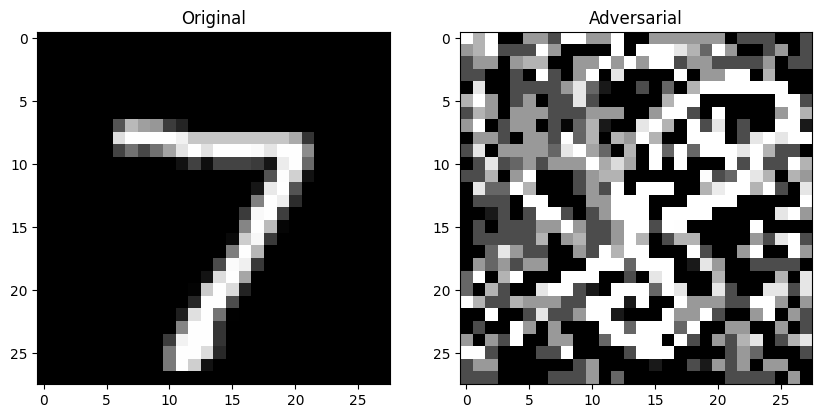

[Defensive Distillation] Epoch 1, Loss: 0.0430
[Defensive Distillation] Epoch 2, Loss: 0.0304
[Defensive Distillation] Epoch 3, Loss: 0.0250
[Defensive Distillation] Epoch 4, Loss: 0.0230
[Defensive Distillation] Epoch 5, Loss: 0.0221
[Defensive Distillation] Epoch 6, Loss: 0.0241
[Defensive Distillation] Epoch 7, Loss: 0.0184
[Defensive Distillation] Epoch 8, Loss: 0.0202
[Defensive Distillation] Epoch 9, Loss: 0.0182
[Defensive Distillation] Epoch 10, Loss: 0.0208
After Defensive Distillation:
Accuracy: 0.9929, Precision: 0.9929, Recall: 0.9929, F1 Score: 0.9929


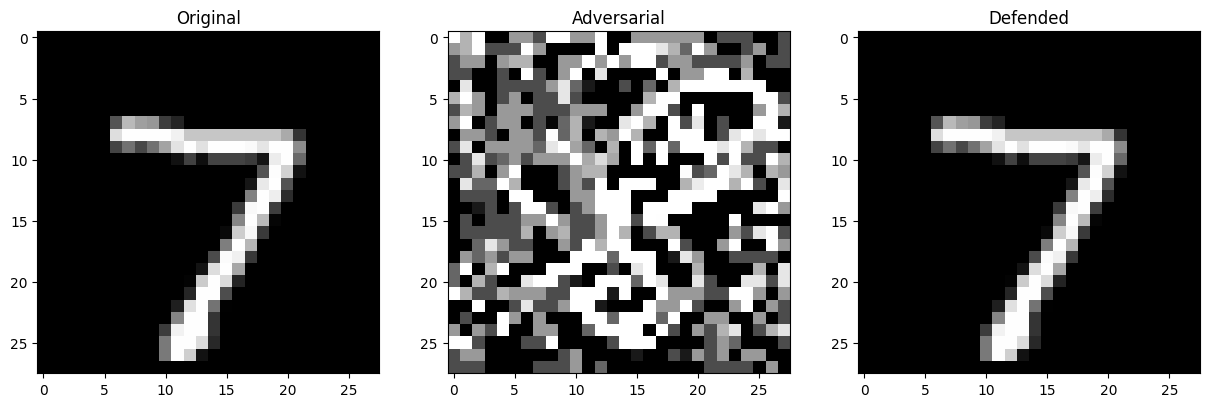

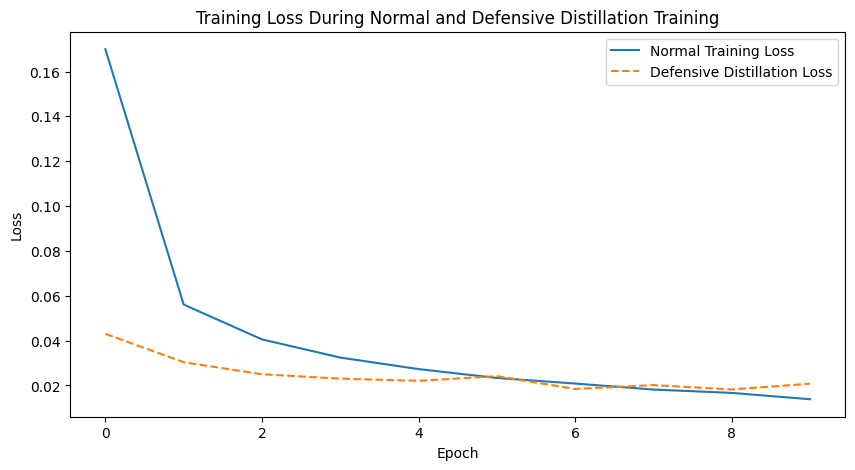

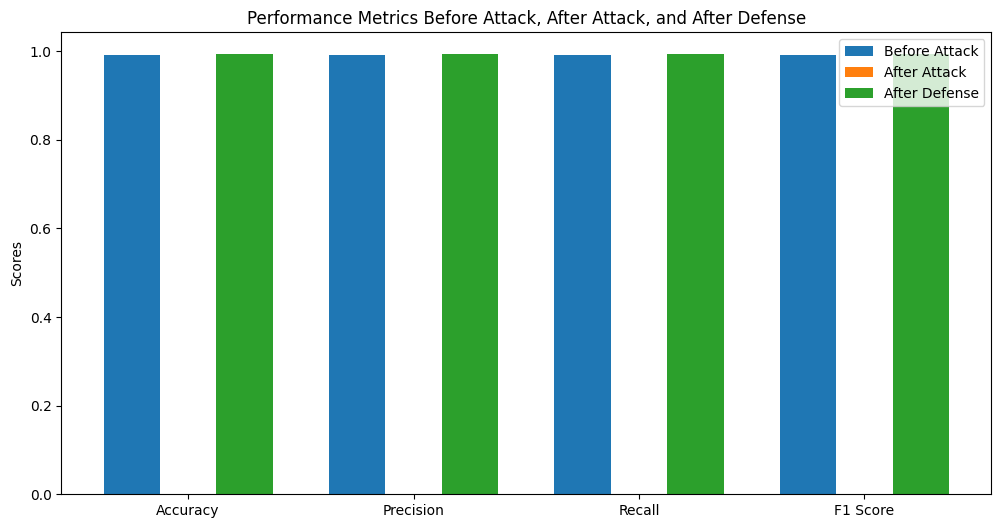

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# ===== 1. تنظیمات اولیه =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Global variable for number of epochs
NUM_EPOCHS = 10

# ===== 2. تعریف مدل =====
class ComplexCNN(nn.Module):
    def __init__(self):
        super(ComplexCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = ComplexCNN().to(device)

# ===== 3. آماده‌سازی داده =====
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ===== 4. تنظیمات آموزش =====
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

def train_model(model, loader, epochs=NUM_EPOCHS):
    model.train()
    loss_values = []
    for epoch in range(1, epochs + 1):
        epoch_loss = 0
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(loader)
        loss_values.append(avg_loss)
        print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")
    return loss_values

loss_values = train_model(model, train_loader, epochs=NUM_EPOCHS)

# ===== 5. حمله اجتنابی جعبه سفید =====
def white_box_evasion_attack(model, data, target, epsilon, iters=10):
    perturbed_data = data.clone().detach().requires_grad_(True).to(device)
    for _ in range(iters):
        output = model(perturbed_data)
        loss = criterion(output, target)
        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            perturbed_data += epsilon * perturbed_data.grad.sign()
            perturbed_data = torch.clamp(perturbed_data, 0, 1).detach().requires_grad_(True)
    return perturbed_data.detach()

# ===== 6. ارزیابی =====
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    accuracy = correct / total
    precision = precision_score(all_targets, all_preds, average='weighted')
    recall = recall_score(all_targets, all_preds, average='weighted')
    f1 = f1_score(all_targets, all_preds, average='weighted')
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    return accuracy, precision, recall, f1

# ارزیابی قبل از حمله
accuracy_before_attack, precision_before_attack, recall_before_attack, f1_before_attack = evaluate_model(model, test_loader)

# ===== 7. اعمال حمله =====
epsilon = 0.3
perturbed_data_list = []
target_list = []
original_samples = []
perturbed_samples = []

for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    perturbed_data = white_box_evasion_attack(model, data, target, epsilon)
    perturbed_data_list.append(perturbed_data)
    target_list.append(target)
    perturbed_samples.append(perturbed_data[0].detach().cpu())
    original_samples.append(data[0].detach().cpu())

perturbed_dataset = TensorDataset(torch.cat(perturbed_data_list), torch.cat(target_list))
perturbed_loader = DataLoader(perturbed_dataset, batch_size=64, shuffle=False)

accuracy_after_attack, precision_after_attack, recall_after_attack, f1_after_attack = evaluate_model(model, perturbed_loader)

# ===== 8. نمایش تصاویر =====
def show_images(original, adversarial, defended=None):
    if defended is not None:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(original.cpu().squeeze(), cmap="gray")
        axes[0].set_title("Original")
        axes[1].imshow(adversarial.cpu().squeeze(), cmap="gray")
        axes[1].set_title("Adversarial")
        axes[2].imshow(defended.cpu().squeeze(), cmap="gray")
        axes[2].set_title("Defended")
    else:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(original.cpu().squeeze(), cmap="gray")
        axes[0].set_title("Original")
        axes[1].imshow(adversarial.cpu().squeeze(), cmap="gray")
        axes[1].set_title("Adversarial")
    plt.show()

show_images(original_samples[0], perturbed_samples[0])

# ===== 9. تکنیک دفاعی: تقطیر تدافعی =====
def defensive_distillation(model, train_loader, temp=10.0, epochs=NUM_EPOCHS):
    model.train()
    distilled_loss_values = []
    for epoch in range(1, epochs + 1):
        epoch_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            soft_target = nn.functional.softmax(model(data) / temp, dim=1)

            optimizer.zero_grad()
            output = model(data)
            distillation_loss = -torch.sum(soft_target * torch.log_softmax(output / temp, dim=1), dim=1).mean()
            distillation_loss.backward()
            optimizer.step()
            epoch_loss += distillation_loss.item()
        avg_loss = epoch_loss / len(train_loader)
        distilled_loss_values.append(avg_loss)
        print(f"[Defensive Distillation] Epoch {epoch}, Loss: {avg_loss:.4f}")
    return distilled_loss_values

defensive_loss_values = defensive_distillation(model, train_loader)

# ===== 10. ارزیابی نهایی =====
defended_samples = []
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    perturbed_data = white_box_evasion_attack(model, data, target, epsilon)
    defended_output = model(perturbed_data)
    defended_samples.append(perturbed_data[0].detach().cpu())
    break

print("After Defensive Distillation:")
accuracy_after_training, precision_after_training, recall_after_training, f1_after_training = evaluate_model(model, test_loader)

# نمایش تصاویر با دفاع
show_images(original_samples[0], perturbed_samples[0], defended_samples[0])

# ===== 11. نمایش نمودارها =====
def plot_metrics(normal_loss, defensive_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(normal_loss, label="Normal Training Loss")
    plt.plot(defensive_loss, label="Defensive Distillation Loss", linestyle="--")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss During Normal and Defensive Distillation Training")
    plt.legend()
    plt.show()

def plot_accuracy_metrics(before_metrics, attack_metrics, defense_metrics):
    labels = ["Accuracy", "Precision", "Recall", "F1 Score"]
    before_values = list(before_metrics)
    attack_values = list(attack_metrics)
    defense_values = list(defense_metrics)

    x = np.arange(len(labels))
    width = 0.25

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width, before_values, width, label="Before Attack")
    ax.bar(x, attack_values, width, label="After Attack")
    ax.bar(x + width, defense_values, width, label="After Defense")

    ax.set_ylabel("Scores")
    ax.set_title("Performance Metrics Before Attack, After Attack, and After Defense")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.show()

plot_metrics(loss_values, defensive_loss_values)
plot_accuracy_metrics((accuracy_before_attack, precision_before_attack, recall_before_attack, f1_before_attack),
                      (accuracy_after_attack, precision_after_attack, recall_after_attack, f1_after_attack),
                      (accuracy_after_training, precision_after_training, recall_after_training, f1_after_training))


Input Reconstructin CIFAR-10

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 1.3765
Epoch 2, Loss: 0.9699
Epoch 3, Loss: 0.8060
Epoch 4, Loss: 0.6961
Epoch 5, Loss: 0.6112
Epoch 6, Loss: 0.5472
Epoch 7, Loss: 0.4949
Epoch 8, Loss: 0.4416
Epoch 9, Loss: 0.4002
Epoch 10, Loss: 0.3642
Accuracy: 0.7891, Precision: 0.7916, Recall: 0.7891, F1 Score: 0.7888
Epoch 1, Defended Loss: 1.7699
Epoch 2, Defended Loss: 1.5998
Epoch 3, Defended Loss: 1.5391
Epoch 4, Defended Loss: 1.5111
Epoch 5, Defended Loss: 1.4848
Epoch 6, Defended Loss: 1.4575
Epoch 7, Defended Loss: 1.4423
Epoch 8, Defended Loss: 1.4177
Epoch 9, Defended Loss: 1.4031
Epoch 10, Defended Loss: 1.3876
Accuracy: 0.1420, Precision: 0.2674, Recall: 0.1420, F1 Score: 0.1074


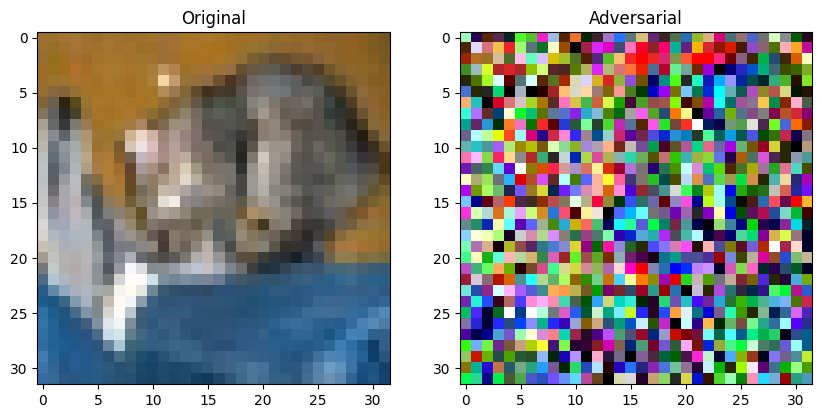

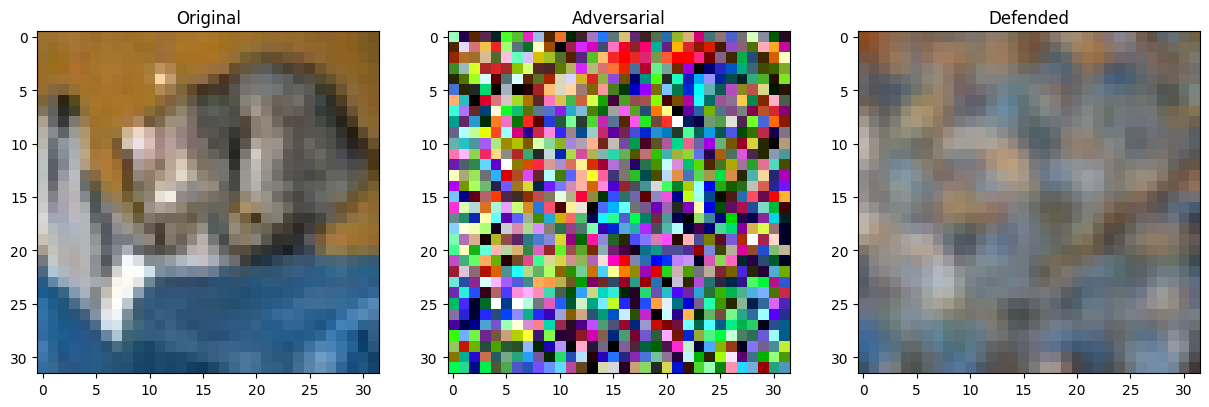

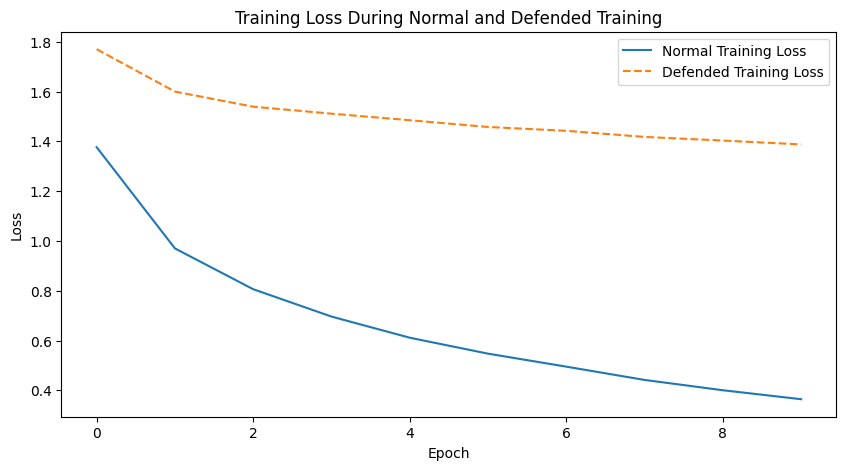

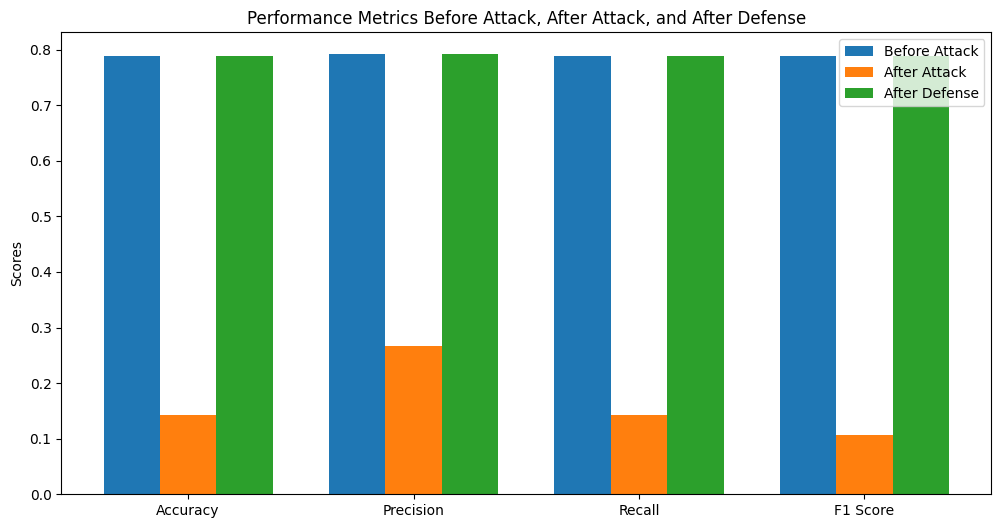

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
from scipy.ndimage import gaussian_filter

# ===== 1. تنظیمات اولیه =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Global variable for number of epochs
NUM_EPOCHS = 10

# ===== 2. تعریف مدل =====
class CIFAR10CNN(nn.Module):
    def __init__(self):
        super(CIFAR10CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CIFAR10CNN().to(device)

# ===== 3. آماده‌سازی داده =====
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ===== 4. تنظیمات آموزش =====
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

def train_model(model, loader, epochs=NUM_EPOCHS):
    model.train()
    loss_values = []
    for epoch in range(1, epochs + 1):
        epoch_loss = 0
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(loader)
        loss_values.append(avg_loss)
        print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")
    return loss_values

loss_values = train_model(model, train_loader, epochs=NUM_EPOCHS)

# ===== 5. حمله اجتنابی جعبه سیاه =====
def black_box_evasion_attack(model, surrogate_model, data, epsilon, iters=10):
    perturbed_data = data.clone().detach().requires_grad_(True).to(device)
    for _ in range(iters):
        output = surrogate_model(perturbed_data)
        loss = criterion(output, output.argmax(dim=1))
        surrogate_model.zero_grad()
        loss.backward()

        with torch.no_grad():
            perturbed_data += epsilon * perturbed_data.grad.sign()
            perturbed_data = torch.clamp(perturbed_data, -1, 1).detach().requires_grad_(True)
    return perturbed_data.detach()

# ===== 6. تعریف مدل جایگزین =====
surrogate_model = CIFAR10CNN().to(device)
surrogate_optimizer = optim.Adam(surrogate_model.parameters(), lr=0.001)

# آموزش مدل جایگزین
def train_surrogate_model(model, loader, epochs=NUM_EPOCHS):
    model.train()
    for epoch in range(1, epochs + 1):
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            surrogate_optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            surrogate_optimizer.step()

train_surrogate_model(surrogate_model, train_loader, epochs=NUM_EPOCHS)

# ===== 7. تکنیک دفاعی: بازسازی ورودی با Gaussian Smoothing =====
def input_reconstruction(data):
    # Apply Gaussian smoothing to reduce perturbations
    data_np = data.cpu().numpy()
    smoothed_data = np.array([gaussian_filter(img, sigma=1) for img in data_np])
    return torch.tensor(smoothed_data, device=device, dtype=torch.float32)

# ===== 8. ارزیابی =====
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    accuracy = correct / total
    precision = precision_score(all_targets, all_preds, average='weighted')
    recall = recall_score(all_targets, all_preds, average='weighted')
    f1 = f1_score(all_targets, all_preds, average='weighted')
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    return accuracy, precision, recall, f1

# ارزیابی قبل از حمله
accuracy_before_attack, precision_before_attack, recall_before_attack, f1_before_attack = evaluate_model(model, test_loader)

# ===== 9. اعمال حمله =====
epsilon = 0.3
perturbed_data_list = []
target_list = []
original_samples = []
perturbed_samples = []

def train_model_on_defended(model, loader, epochs=NUM_EPOCHS):
    model.train()
    loss_values = []
    for epoch in range(1, epochs + 1):
        epoch_loss = 0
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            perturbed_data = black_box_evasion_attack(model, surrogate_model, data, epsilon)
            defended_data = input_reconstruction(perturbed_data)

            optimizer.zero_grad()
            output = model(defended_data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(loader)
        loss_values.append(avg_loss)
        print(f"Epoch {epoch}, Defended Loss: {avg_loss:.4f}")
    return loss_values

for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    perturbed_data = black_box_evasion_attack(model, surrogate_model, data, epsilon)
    perturbed_data_list.append(perturbed_data)
    target_list.append(target)
    perturbed_samples.append(perturbed_data[0].detach().cpu())
    original_samples.append(data[0].detach().cpu())

perturbed_dataset = TensorDataset(torch.cat(perturbed_data_list), torch.cat(target_list))
perturbed_loader = DataLoader(perturbed_dataset, batch_size=64, shuffle=False)

defended_loss_values = train_model_on_defended(model, train_loader, epochs=NUM_EPOCHS)
accuracy_after_attack, precision_after_attack, recall_after_attack, f1_after_attack = evaluate_model(model, perturbed_loader)

# ===== 10. نمایش تصاویر =====
def show_images(original, adversarial, defended=None):
    if defended is not None:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(original.cpu().permute(1, 2, 0) * 0.5 + 0.5)
        axes[0].set_title("Original")
        axes[1].imshow(adversarial.cpu().permute(1, 2, 0) * 0.5 + 0.5)
        axes[1].set_title("Adversarial")
        axes[2].imshow(defended.cpu().permute(1, 2, 0) * 0.5 + 0.5)
        axes[2].set_title("Defended")
    else:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(original.cpu().permute(1, 2, 0) * 0.5 + 0.5)
        axes[0].set_title("Original")
        axes[1].imshow(adversarial.cpu().permute(1, 2, 0) * 0.5 + 0.5)
        axes[1].set_title("Adversarial")
    plt.show()

show_images(original_samples[0], perturbed_samples[0])

# نمایش تصاویر با دفاع
defended_samples = []
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    perturbed_data = black_box_evasion_attack(model, surrogate_model, data, epsilon)
    defended_data = input_reconstruction(perturbed_data)
    defended_samples.append(defended_data[0].detach().cpu())
    break

show_images(original_samples[0], perturbed_samples[0], defended_samples[0])

# ===== 11. نمایش نمودارها =====
def plot_metrics(normal_loss, defended_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(normal_loss, label="Normal Training Loss")
    plt.plot(defended_loss, label="Defended Training Loss", linestyle="--")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss During Normal and Defended Training")
    plt.legend()
    plt.show()

def plot_accuracy_metrics(before_metrics, attack_metrics, defense_metrics):
    labels = ["Accuracy", "Precision", "Recall", "F1 Score"]
    before_values = list(before_metrics)
    attack_values = list(attack_metrics)
    defense_values = list(defense_metrics)

    x = np.arange(len(labels))
    width = 0.25

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width, before_values, width, label="Before Attack")
    ax.bar(x, attack_values, width, label="After Attack")
    ax.bar(x + width, defense_values, width, label="After Defense")

    ax.set_ylabel("Scores")
    ax.set_title("Performance Metrics Before Attack, After Attack, and After Defense")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.show()

plot_metrics(loss_values, defended_loss_values)
plot_accuracy_metrics((accuracy_before_attack, precision_before_attack, recall_before_attack, f1_before_attack),
                      (accuracy_after_attack, precision_after_attack, recall_after_attack, f1_after_attack),
                      (accuracy_before_attack, precision_before_attack, recall_before_attack, f1_before_attack))
